In [1]:
import os, cv2, glob, random, math
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from enum import Enum
from tqdm import *
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
mask1 = cv2.imread('data/primer/primeruji/label/lbgr_5.png',3)
mask2 = cv2.imread('data/sawit/Data Oil Palm/train_label/0027.png',3)
print(np.unique(mask1))
print(np.unique(mask2))

In [ ]:
clahe = cv2.createCLAHE(clipLimit = 0.82, tileGridSize=(4,4)) #parameter ditetapkan untuk CLAHE
path = 'data/primer/Preprocessing2'  # folder menyimpan hasil proses CLAHE+MB
for i, img in enumerate(glob.glob("data/primer/Foto Asli - 1/*.jpg"), 1):  #proses inisiasi iterasi data yang diambil
    img_palm = cv2.imread(img)   # membaca data 
    img_palm = cv2.cvtColor(img_palm, cv2.COLOR_BGR2YUV)  #konversi ruang warna BGR ke YUV
    img_palm[:,:,2] = cv2.medianBlur(clahe.apply(img_palm[:,:,2]),3) # penggabungan operasi CLAHE+MB
    img_palm = cv2.cvtColor(img_palm,cv2.COLOR_YUV2BGR)  #pengembalian opeasi konversi warna dari YUV ke BGR
    cv2.imwrite(os.path.join(path, 'DJI_{}.jpg'.format(i)), img_palm)  #memberi nama file


In [ ]:
clahe2 = cv2.createCLAHE(clipLimit = 0.82, tileGridSize=(4,4))
path2 = 'data/primer/Preprocessing1'
for i, img2 in enumerate(glob.glob("data/primer/Foto Asli - 2/*.jpg"), 1):
    img_palm2 = cv2.imread(img2)
    #img_palm2 = cv2.cvtColor(img_palm2, cv2.COLOR_BGR2RGB)
    img_palm2 = cv2.cvtColor(img_palm2, cv2.COLOR_BGR2YUV)
    img_palm2[:,:,2] = cv2.medianBlur(clahe2.apply(img_palm2[:,:,2]),3)
    img_palm2 = cv2.cvtColor(img_palm2,cv2.COLOR_YUV2BGR)
    cv2.imwrite(os.path.join(path2, 'DJI_{}.jpg'.format(451+i)), img_palm2)

In [5]:
#Proses Pelabelan Citra
#0:[0,0,0], 28:[248,0,0],74:[0,0,248], 146:[0,248,0]
#                B                R            G
#0:[0,0,0] 1:[248,0,0],2:[0,0,248], 3:[0,248,0], 
def plot_image (im, judul = "Image"):
    """ Plot citra dengan plt.imshow"""
    plt.figure()
    if len(im.shape)==3:
        im_rgb= cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        plt.axis('off')
        plt.title(f"{judul}") 
        plt.imshow(im_rgb)
    else:
        plt.axis('off')
        plt.title(f"{judul}") 
        plt.imshow(im, cmap = "gray")

def unik_color(im):
    """ Mencari warna yang unik pada array 2D"""
    # Flaten image dari 3 dimensi jadi 1 dimensi
    im_val = im.flatten()
    # Dapatkan jumlah baris lalu reshape
    n_row = int(len(im_val)/3)
    new_im = im_val.reshape((n_row,3))
    
    # Hitung nilai unique yang muncul
    # Untuk mengecek apakah benar jumlah warnanya hanya ada 4
    # warna_unik = warna2 yang ada di citranya
    warna_unik = np.unique(new_im, axis=0) 
    list_warna = list(warna_unik)
    return list_warna

def convert_w2b(im):
    """Konversi warna putih ke warna hitam"""
    m,n,_=im.shape
    for i in range (0,m):
        for j in range(0,n):
            if np.all(im[i,j,:]==248):
                im[i,j,:]=np.array([0,0,0])
    for i in range (0,m):
        for j in range(0,n):
            if (im[i,j,2]>=240) and (im[i,j,1]==0) and (im[i,j,0]==0):
                im[i,j,:]=np.array([0,0,0])            
    return im

def BGR2label(im):
    """Konversi mask ke 1,2,3,4 (1:tanah/jalan 2: Sawit 3: parit/kubangan 4:tanaman lain)"""
    gray= cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    mask = np.zeros_like(gray)
    #warna_unik = list(np.unique(gray)) 
    #print(warna_unik)
    warna_unik = [0, 20, 70, 140, 240]
    label = [0,1,2,3]
    for i in range(len(warna_unik)-1):
        logika = np.logical_and(gray >= warna_unik[i], gray < warna_unik[i+1]-15)*1*label[i]
        mask = mask+logika
    return mask

def BGR2label3(im):
    """Konversi mask ke 1,2,3(1:tanah/jalan 2: vegetasi 3: parit/kubangan) """
    gray= cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    mask = np.zeros_like(gray)
    warna_unik = list(np.unique(gray)) 
    print(warna_unik)
    warna_unik = [0, 25, 130, 240]
    label = [0,1,2]
    for i in range(len(warna_unik)-1):
        logika = np.logical_and(gray >= warna_unik[i], gray < warna_unik[i+1]-15)*1*label[i]
        mask = mask+logika
    return mask

# ================ LABELING ============

def label2BGR(mask):
    """Konversi dari mask ke B,G,R"""
    B = (mask==1)*1*248
    R = (mask==1)*1*248
    G = (mask==1)*1*248
    color_im = cv2.merge([B,G,R])
    return color_im.astype(np.uint8)

def label2BGR3(mask):
    color_map = np.array([[0, 0, 0], [248, 0, 0], [0, 255, 0]], dtype=np.uint8)
    bgr_image = color_map[mask]
    return bgr_image

[0, 28]
[0, 1]


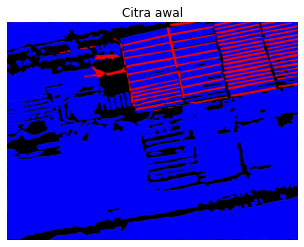

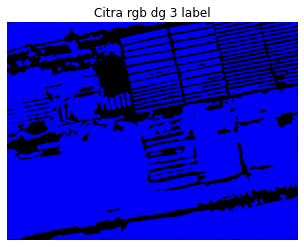

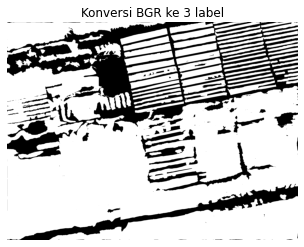

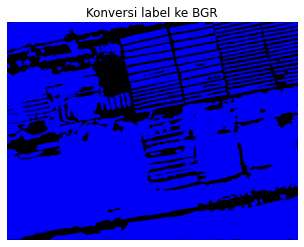

In [54]:
#=======================================================
# Citra awal
img = cv2.imread("data/primer/primeruji/mask2/156m3.png")
img_baru = convert_w2b(img.copy())
mask_label = BGR2label3(img_baru)
wu = list(np.unique(mask_label)) 
print(wu)
konversi_bgr = label2BGR3(mask_label)
# cv2.imwrite("data/primer/primeruji/label/l_84.png", mask_label)
# cv2.imwrite("data/primer/primeruji/label2/lbgr_84.png",konversi_bgr)

#Rotasi
plot_image(img, "Citra awal")
plot_image(img_baru, "Citra rgb dg 3 label")
plot_image(mask_label, "Konversi BGR ke 3 label")
plot_image(konversi_bgr, "Konversi label ke BGR")

In [ ]:
# Pemrosesan mask 4 kelas label color
lb = 'data/primer/primeruji/label2/'
for i, img in enumerate(glob.glob("data/primer/primeruji/mask2/*.png"), 1):
    image = cv2.imread(img)
    img_baru = convert_w2b(image.copy())
    mask_label = BGR2label(img_baru)
    konversi_bgr = label2BGR(mask_label)
    cv2.imwrite(os.path.join(lb, 'lbgr_{}.png'.format(i)), konversi_bgr)

In [ ]:
# Pemrosesan mask 4 kelas label gray
lb = 'data/primer/primeruji/label/'
for i, img in enumerate(glob.glob("data/primer/primeruji/mask2/*.png"), 1):
    image = cv2.imread(img)
    img_baru = convert_w2b(image.copy())
    mask_label = BGR2label(img_baru)
    konversi_bgr = label2BGR(mask_label)
    cv2.imwrite(os.path.join(lb, 'l_{}.png'.format(i)), mask_label)

In [3]:
# Pemrosesan mask 3 kelas label gray
mask = 'data/primer/primeruji/mask3Color/'
for i, img in enumerate(glob.glob("data/primer/primeruji/mask1/*.png"), 1):
    image = cv2.imread(img)
    img_baru = convert_w2b(image.copy())
    cv2.imwrite(os.path.join(mask, 'm3_{}.png'.format(i)), img_baru)

KeyboardInterrupt: 

In [55]:
# Pemrosesan mask 3 kelas label gray dan mask
lb1 = 'data/primer/primeruji/label3klas/'
lb2 = 'data/primer/primeruji/labelColor3klas/'
for i, img in enumerate(glob.glob("data/primer/primeruji/mask1/*.png"), 1):
    image = cv2.imread(img)
    img_baru = convert_w2b(image.copy())
    mask_label = BGR2label3(img_baru)
    konversi_bgr =  label2BGR3(mask_label)
    cv2.imwrite(os.path.join(lb1, 'l3_{}.png'.format(i)), mask_label)
    cv2.imwrite(os.path.join(lb2, 'lbgr3_{}.png'.format(i)), konversi_bgr)       

[0, 28]
[0, 29, 150, 255]
[0, 28, 146]
[0, 28, 146]
[0, 29, 150, 255]
[0, 28, 146]
[0, 28, 146]
[0, 28, 146]
[0, 28, 146]
[0, 28, 146]
[0, 29, 150, 255]
[0, 28, 146]
[0, 28, 146]
[0, 28, 146]
[0, 29, 150, 255]
[0, 28, 146]
[0, 29, 150, 255]
[0, 28, 146]
[0, 28, 146]
[0, 29, 150, 255]
[0, 29, 150, 255]
[0, 28, 146]
[0, 29, 150, 255]
[0, 29, 150, 255]
[0, 29, 150, 255]
[0, 28, 146]
[0, 29, 150, 255]
[0, 29, 150, 255]
[0, 28, 146]
[0, 28, 146]


======= SPLIT IMAGE =================

In [3]:
#rename file 
folderSpli256 = 'data/primer/primeruji/trainSplit/'
for count, filename in enumerate(os.listdir(folderSpli256)):
    dst = f"S_{count+1}.png"
    src =f"{folderSpli256}/{filename}"  # foldername/filename, if .py file is outside folder
    dst =f"{folderSpli256}/{dst}"
    # rename() function will
    # rename all the files
    os.rename(src, dst)


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data/primer/primeruji/trainSplit//S_10.png' -> 'data/primer/primeruji/trainSplit//S_2.png'

In [19]:
isplit = 'data/primer/primeruji/trainSplit512/'
s = 2560
k = 1
for i, img in enumerate(glob.glob("data/primer/primeruji/train/*.jpg"), 1):  
    imgp = cv2.imread(img)
    imgp = cv2.resize(imgp, (s,s))
    h,w,c = imgp.shape
    th, tw = 512, 512
    list_crop = []
    for i in range (0, s, th):
        for j in range(0, s, tw):
            im = imgp.copy()
            t_array = im[i:i+th, j:j+tw,:c]
            cv2.imwrite(os.path.join(isplit, f'S2_{0+k}.png'), t_array)
            k=k+1
'''
img = cv2.imread('data/primer/primeruji/train/DJI_463.jpg')
img = cv2.resize(img, (2560,2560))
plot_image(img, "Citra")    
print(img.shape)

h,w,c = img.shape
th, tw = 512, 512
# t_array = np.zeros((int(h//th), int(w/tw), th, tw, c))
list_crop = []
k=1
for i in range (0, 2560, th):
    for j in range(0, 2560, th):
        im = img.copy()
        t_array = im[i:i+th, j:j+tw,:c]
#         list_crop.append(t_array)
        cv2.imwrite(os.path.join(isplit, f'S2_{150+k}.png'), t_array)
        k=k+1
# for crop in list_crop:
#     plot_image(crop, "Citra split")  
'''

'\nimg = cv2.imread(\'data/primer/primeruji/train/DJI_463.jpg\')\nimg = cv2.resize(img, (2560,2560))\nplot_image(img, "Citra")    \nprint(img.shape)\n\nh,w,c = img.shape\nth, tw = 512, 512\n# t_array = np.zeros((int(h//th), int(w/tw), th, tw, c))\nlist_crop = []\nk=1\nfor i in range (0, 2560, th):\n    for j in range(0, 2560, th):\n        im = img.copy()\n        t_array = im[i:i+th, j:j+tw,:c]\n#         list_crop.append(t_array)\n        cv2.imwrite(os.path.join(isplit, f\'S2_{150+k}.png\'), t_array)\n        k=k+1\n# for crop in list_crop:\n#     plot_image(crop, "Citra split")  \n'

In [20]:
isplitm = 'data/primer/primeruji/maskSplit256/'
s = 2560
k2 = 1
for i, imgm in enumerate(glob.glob("data/primer/primeruji/mask1/*.png"), 1):
    imgp = cv2.imread(imgm)
    imgp = cv2.resize(imgp, (s,s))
    h,w,c = imgp.shape
    th, tw = 256, 256
    for i in range (0, s, th):
        for j in range(0, s, tw):
            im = imgp.copy()
            t_array = im[i:i+th, j:j+tw,:c]
            cv2.imwrite(os.path.join(isplitm, f'S2_{0+k2}.png'), t_array)
            k2=k2+1
'''
imgm = cv2.imread('data/primer/primeruji/mask2/463m3.png')
imgm = cv2.resize(imgm, (2560,2560))
plot_image(imgm, "Citra")    
print(imgm.shape)

h,w,c = imgm.shape
th, tw = 512, 512
# t_array = np.zeros((int(h//th), int(w/tw), th, tw, c))
k=1
for i in range (0, 2560, th):
    for j in range(0, 2560, th):
        im = imgm.copy()
        t_array = im[i:i+th, j:j+tw,:c]
        cv2.imwrite(os.path.join(isplitm, f'S2_{150+k}.png'), t_array)
        k=k+1
'''

'\nimgm = cv2.imread(\'data/primer/primeruji/mask2/463m3.png\')\nimgm = cv2.resize(imgm, (2560,2560))\nplot_image(imgm, "Citra")    \nprint(imgm.shape)\n\nh,w,c = imgm.shape\nth, tw = 512, 512\n# t_array = np.zeros((int(h//th), int(w/tw), th, tw, c))\nk=1\nfor i in range (0, 2560, th):\n    for j in range(0, 2560, th):\n        im = imgm.copy()\n        t_array = im[i:i+th, j:j+tw,:c]\n        cv2.imwrite(os.path.join(isplitm, f\'S2_{150+k}.png\'), t_array)\n        k=k+1\n'

In [ ]:
isplitl = 'data/primer/primeruji/labelSplit256/'
s = 2560
k1 = 1
for i, img1 in enumerate(glob.glob("data/primer/primeruji/label30/*.png"), 1):
    imgp = cv2.imread(img1)
    imgp = cv2.resize(imgp, (s,s))
    h,w,c = imgp.shape
    th, tw = 256, 256
    for i in range (0, s, th):
        for j in range(0, s, tw):
            im = imgp.copy()
            t_array = im[i:i+th, j:j+tw,:c]
            cv2.imwrite(os.path.join(isplitl, f'S2_{0+k1}.png'), t_array)
            k1=k1+1
'''
imgl = cv2.imread('data/primer/primeruji/label/l_15.png')
imgl = cv2.resize(imgl, (2560,2560))
    h,w,c = imgl.shape
th, tw = 512, 512    # th, tw = 256, 256
# t_array = np.zeros((int(h//th), int(w/tw), th, tw, c))
k=1
for i in range (0, 2560, th):
    for j in range(0, 2560, th):
        im = imgl.copy()
        t_array = im[i:i+th, j:j+tw,:c]
        cv2.imwrite(os.path.join(isplitl, f'S2_{150+k}.png'), t_array)
        k=k+1
'''

# SPLIT GT 512 dan 256 #

In [4]:
sg1 = 'data/primer/primeruji/gtSplit256/'
s = 2560
k1 = 1
for i, img1 in enumerate(glob.glob("data/primer/primeruji/gt/*.png"), 1):
    imgp = cv2.imread(img1)
    imgp = cv2.resize(imgp, (s,s))
    h,w,c = imgp.shape
    th, tw = 256, 256
    for i in range (0, s, th):
        for j in range(0, s, tw):
            im = imgp.copy()
            t_array = im[i:i+th, j:j+tw,:c]
            cv2.imwrite(os.path.join(sg1, f'SGT256_{0+k1}.png'), t_array)
            k1=k1+1

In [3]:
sg = 'data/primer/primeruji/gtSplit512/'
s = 2560
k = 1
for i, img in enumerate(glob.glob("data/primer/primeruji/gt/*.png"), 1):  
    imgp = cv2.imread(img)
    imgp = cv2.resize(imgp, (s,s))
    h,w,c = imgp.shape
    th, tw = 512, 512
    list_crop = []
    for i in range (0, s, th):
        for j in range(0, s, tw):
            im = imgp.copy()
            t_array = im[i:i+th, j:j+tw,:c]
            cv2.imwrite(os.path.join(sg, f'SGT512_{0+k}.png'), t_array)
            k=k+1

======= AUGMENTATION IMAGE to Horizontal, Vertical, Horisontal + Vertica to the image mask =================

In [ ]:
''' flip the maskimage horizontally '''
lbr = 'data/primer/primeruji/labelRotasi/'
for i, img in enumerate(glob.glob("data/primer/primeruji/mask2/*.png"),1):
    image = cv2.imread(img)
    horizontal_flip = cv2.flip(image, flipCode=1)
    cv2.imwrite(os.path.join(lbr, 'mh_{}.png'.format(30+i)), horizontal_flip)

In [ ]:
# flip the mask image vertically
for i, img in enumerate(glob.glob("data/primer/primeruji/mask2/*.png"),1):
    image = cv2.imread(img)
    vertical_flip = cv2.flip(image, flipCode=0)
    cv2.imwrite(os.path.join(lbr, 'mv_{}.png'.format(60+i)), vertical_flip)

In [ ]:
# flip the mask image  both horizontally and vertically
for i, img in enumerate(glob.glob("data/primer/primeruji/mask2/*.png"),1):
    image = cv2.imread(img)
    flip_image = cv2.flip(image, flipCode=-0)
    flip_image = cv2.flip(flip_image, flipCode=1)
    cv2.imwrite(os.path.join(lbr, 'mvh_{}.png'.format(90+i)), flip_image)

In [ ]:
======= AUGMENTATION IMAGE to Horizontal, Vertical, Horisontal + Vertical to train data =================

In [ ]:
''' the image train '''
train = 'data/primer/primeruji/trainRot/'
for i, img in enumerate(glob.glob("data/primer/primeruji/train/*.jpg"),1):
    image = cv2.imread(img)
    cv2.imwrite(os.path.join(train, 'DJI_{}.jpg'.format(i)), image)

In [ ]:
''' flip the image train horizontally '''
for i, img in enumerate(glob.glob("data/primer/primeruji/train/*.jpg"),1):
    image = cv2.imread(img)
    horizontal_flip = cv2.flip(image, flipCode=1)
    cv2.imwrite(os.path.join(train, 'DJI_{}.jpg'.format(30+i)), horizontal_flip)

In [ ]:
# flip the train image vertically
for i, img in enumerate(glob.glob("data/primer/primeruji/train/*.jpg"),1):
    image = cv2.imread(img)
    vertical_flip = cv2.flip(image, flipCode=0)
    cv2.imwrite(os.path.join(train, 'DJI_{}.jpg'.format(60+i)), vertical_flip)

In [ ]:
# flip the train image both horizontally and vertically
for i, img in enumerate(glob.glob("data/primer/primeruji/train/*.jpg"),1):
    image = cv2.imread(img)
    flip_image = cv2.flip(image, flipCode=-0)
    flip_image = cv2.flip(flip_image, flipCode=1)
    cv2.imwrite(os.path.join(train, 'DJI_{}.jpg'.format(90+i)), flip_image)

In [ ]:
# from PIL import Image
# img = Image.open("data/primer/primeruji/mask2/171m3.png")
# flipped = img.transpose(Image.FLIP_TOP_BOTTOM)

img = cv2.imread("data/primer/primeruji/mask2/171m3.png")

# flip the image horizontally
horizontal_flip = cv2.flip(img, flipCode=1)
cv2.imwrite("data/primer/primeruji/mask2/l_32.png", mask_label)
cv2.imshow("Horizontal flip", horizontal_flip_img)
print(f"[INFO] flipping image horizontally...")
cv2.waitKey(0)

# flip the image vertically
vertical_flip = cv2.flip(image, flipCode=0)
cv2.imwrite("data/primer/primeruji/mask2/l_62.png",konversi_bgr)
cv2.imshow("Vertical flip", vertical_flip_img)
print(f"[INFO] flipping image vertically...")
cv2.waitKey(0)

# flip the image both horizontally and vertically
flip_image = cv2.flip(image, flipCode=-0)
flip_image = cv2.flip(image, flipCode=-1)
cv2.imwrite("data/primer/primeruji/label2/lbgr_8.png",konversi_bgr)
cv2.imshow("Horizontal and vertical flip", flip_image)
print(f"[INFO] flipping image horizontally and then vertically...")
# waits for any key to be pressed then remove any
# created gui window from the screen & memory
cv2.waitKey(0)
cv2.destroyAllWindows()